# Defining the tennis game

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re

def tennis_game(p):
    M = np.array([
    [0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (0, 0) - 0
    [0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (15, 0) - 1
    [0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (0, 15) - 2
    [0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0, 0], # (30, 0) - 3
    [0, 0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0, 0], # (15, 15) - 4
    [0, 0, 0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0, 0, 0, 0, 0], # (0, 30) - 5
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1-p, 0, p, 0, 0, 0, 0], # (40, 0) - 6
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 0, 0, 1-p, 0, 0], # (30, 15) - 7
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1-p, 0, 0, p, 0, 0], # (15, 30) - 8
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 0, 0, 0, 1-p], # (0, 40) - 9
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 1-p, 0, 0, 0], # (40, 15) - 10
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 1-p], # (15, 40) - 11
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], # (Win, 0) - 12
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 1-p, 0, 0], # (40, 30) - 13
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 1-p, 0], # (30, 30) - 14
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, p, 0, 1-p], # (30, 40) - 15
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # (0, Win) - 16
    ])
    return M

def extract_canonical_components(M):
    D = np.diag(M)
    absorbing, transient = np.where(D==1)[0], np.where(D!=1)[0]
    I = M[absorbing, :][:, absorbing]
    Q = M[transient, :][:, transient]
    R = M[transient, :][:, absorbing]
    O = M[absorbing, :][:, transient]
    return I, Q, R, O, absorbing, transient


# Creating the player and evaluating their choice of breaks

The main player can have both negative and positive decay rates. A negative rate of decay indicates the the opposition gets fatigued quicker than the main player while a positive rate of decay indicates the main players get fatigued quicker.

In [2]:
TOTAL_LENGTH = 55 #total number of games in a match

def player_func(p, rate_of_decay, t):
    return  2*p / (1 + np.exp(rate_of_decay * t ))

def recovery_func(player, base_rec =0.2):
    # effectiveness = 1 - t/TOTAL_LENGTH
    # boost = base_rec * effectiveness
    # player.p = min(player.p*(1 + boost), player.init_p) # ensure p does not exceed initial value
    # player.time_since_last_recovery = t
    player.player_t *= base_rec

class Player:
    def __init__(self, p_func, recover_func, p, break_times, decay_rate):
        self.p_func = p_func
        self.recover_func = recover_func
        self.p = p
        self.time_since_last_recovery = 0
        self.rate_of_decay = decay_rate
        self.break_times = break_times
        self.player_t = 0 #This is related the calculating the player's performance over time
        self.t = 0 # This is the time in the match, which is used to determine when to recover

    def eval_p(self):
        if self.t in self.break_times:
            self.recover_func(self)
        self.t += 1
        self.player_t += 1
        return self.p_func(self.p, self.rate_of_decay, self.player_t)

    def __str__(self):
        return f"Player(p={self.p}, break_times={self.break_times})"
    
    def reset(self):
        self.t = 0
        self.player_t = 0
        self.time_since_last_recovery = 0
        return self
        

def eval_fitness(match_result):
    return len([1 for r in match_result if r == 1]) / len(match_result)

player_gen = lambda p, break_times, decay_rate: Player(
    p_func=player_func,
    recover_func=recovery_func,
    p=p,
    break_times=break_times,
    decay_rate=decay_rate
)


# Simulating a tennis match


Winner: 1


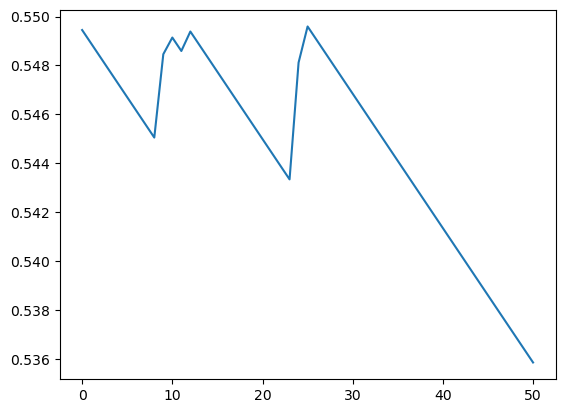

In [3]:
def simulate_game(M, max_iter=300):
    pos = [0]
    for i in range(max_iter):
        pos_next = np.random.choice(len(M), p=M[pos[-1]])
        if pos_next == pos[-1]:
            return pos + [pos_next] 
        else:
            pos += [pos_next]
    #Got stuck in a loop, game was not able to be resolved
    return 3

def simulate_set(p1):
    game_results = []
    p1_wins = 0
    p2_wins = 0
    t = 0
    p1_p_list = []
    while p1_wins < 6 and p2_wins < 6:
        game_result = simulate_game(tennis_game(p1.eval_p()))
        p1_p_list.append(p1.eval_p())
        if game_result == -1:
            print("Game could not be resolved.")
            return -1
        if game_result[-1] == 12:  # Player 1 wins
            p1_wins += 1
        elif game_result[-1] == 16:  # Player 2 wins
            p2_wins += 1
        game_results.append(1 if game_result[-1] == 12 else 2)
        t += 1
    res = [0, game_results]
    if p1_wins == 6:
        res[0] = 1
    elif p2_wins == 6:
        res[0] = 2
    else:
        print("Set could not be resolved.")
        res[0] = 3
    # print(f"Set result: {res[0]}, P1 wins: {p1_wins}, P2 wins: {p2_wins}")
    return res, p1_p_list
    
#The second player's chance of winning is 1 - p1's chance so we do not need to create it.
def simulate_match(p1, max_sets=5):
    sets = []
    set_results = []
    evolution_p = []
    for i in range(max_sets):
        [set_winner, set_result], p1_p_list = simulate_set(p1)
        evolution_p.extend(p1_p_list)
        if set_winner == 3:
            print(f"Set {i+1} could not be resolved.")
            break
        sets.append(set_winner)
        set_results.append([set_result])
    counts = np.bincount(sets)
    winner = np.argmax(counts) 

    return winner, sets, set_results, evolution_p
 

p1 = Player(player_func, recovery_func, 0.55, [18 ,20 ,25, 48, 50, 51], 0.001)
winner,_,_, evolution_p = simulate_match(p1)
print("Winner:", winner)
plt.plot(evolution_p)

# Monte Carlo simulation of several matches

In [4]:
def monte_carlo_matches(p1, reps, verbose=False):
    ties = 0
    winners = []
    # final_transients = []
    # game_lengths = []
    for i in range(reps):
        if verbose: print('Simulating game {0}'.format(i))
        winner, match, match_results, evolution_p = simulate_match(p1)
        tie = (type(match) in [int])
        if verbose: print('Game was {0} a tie'.format((1-tie)*'not'))
        ties += tie 
        # if not tie:
        winners.append(winner)  
        p1.reset()
            # final_transients += [game[-3]]
            # if verbose: print('Winner was {0}, Second Last State was {1}'.format(winners[-1], final_transients))
    # game_lengths += [len(game)-2]
    winners = np.array(winners)
    # final_transients = np.array(final_transients)
    return winners

# p1 = Player(player_func, recovery_func,0.55, [18 ,20 ,25, 48, 50, 51], 0.001)
# win = monte_carlo_matches(p1, 1000)
# print(eval_fitness(win))


# Genetic algorithm

In [5]:
from collections import defaultdict

def crossover(p1, p2):
    cross_times = np.unique(np.concatenate([np.random.choice(p1.break_times, 3, replace=False), np.random.choice(p2.break_times, 3, replace=False)]))
    while len(cross_times) < 6:
        cross_times = np.unique(np.concatenate([cross_times, np.random.choice(TOTAL_LENGTH, 6-len(cross_times), replace=False)]))
    #We are optimising over the same player, so its initial prob of winning should be the same. 
    return Player(player_func, recovery_func, p1.p, cross_times, p1.rate_of_decay)

def mutation(p1):
    idx_to_mutate = np.random.randint(0, 5)
    break_to_mutate = p1.break_times[idx_to_mutate]
    inc = 1
    new_time = break_to_mutate 
    while new_time in p1.break_times:
        # TODO need modulo and all that shit to handle break times
        new_time = break_to_mutate + inc
        if new_time <= 0 or new_time >= TOTAL_LENGTH + 1:
            break
        if inc < 0:
            inc -= 1
        inc *= -1
    p1.break_times[idx_to_mutate] = new_time
    return Player(player_func, recovery_func, p1.p, p1.break_times, p1.rate_of_decay)

def genetic_algorithm(p, decay_rate, mut_p, cross_p, n_elite =1, population_size=10, generations=100, verbose=False):
    fitness_history = defaultdict(lambda : [0,0]) #To smooth out various fitnesses for the same set of break times
    population = [Player(player_func, recovery_func, p, np.random.choice(range(TOTAL_LENGTH), 6, replace=False), decay_rate) for _ in range(population_size)]
    for i in range(generations):
        print(f'Generation {i+1}/{generations}')
        fitness_scores = np.array([])
        for player in population:
            winners = monte_carlo_matches(player, 100)
            sorted_breaks = np.sort(player.break_times).tostring()
            fitness_history[sorted_breaks][1] += 1
            fitness_history[sorted_breaks][0] += eval_fitness(winners)
            avg_fitness = fitness_history[sorted_breaks][0] / fitness_history[sorted_breaks][1]
            fitness_scores = np.append(fitness_scores, [avg_fitness])
        
        sorted_indices = np.argsort(fitness_scores)[::-1]
        next_generation = [population[i].reset() for i in sorted_indices[:n_elite]]
        
        if verbose: print(fitness_scores)
        f_total = sum(fitness_scores)
        if f_total == 0: 
            print("All fitness scores are zero, cannot proceed with selection.")
            return None
        
        fitness_scores = fitness_scores / f_total
        
        while len(next_generation) < population_size:
            idx = np.random.choice(population_size, p=fitness_scores)
            new_player = population[idx].reset()
            if np.random.rand() < cross_p:
                partner_idx = np.random.choice(population_size, p=fitness_scores)
                new_player = crossover(new_player, population[partner_idx])
            elif np.random.rand() < mut_p:
                new_player = mutation(new_player)
            # if verbose: print(f'Creating new player with break_times={new_player.break_times}')
            next_generation.append(new_player)
        if verbose: print('Best break times found so far {}. Fitness is {}'.format(population[sorted_indices[0]].break_times, fitness_scores[sorted_indices[0]]*f_total))
        population = next_generation

    best_player_idx = np.argmax(fitness_scores)
    best_player = population[best_player_idx]
    print(f'Best player for initial probability {best_player.p} and break times {best_player.break_times}. Fitness is {fitness_scores[best_player_idx]*f_total}')
    return best_player, fitness_scores[best_player_idx]*f_total
        
# genetic_algorithm(0.55, 0.00005, 0.2, 0.3, n_elite=4, population_size=10, generations=20, verbose=True)

### Ensuring that we can load results from previous runs of the genetic algorithm
The algorithm is relatively expensive to run to being able to save results will save a lot of time

In [6]:
def save_results(player_fitness_list, filename='results.csv'):
    with open(filename, 'w') as f:
        f.write('p, decay_rate, fitness, break_times\n')
        for player, fitness in player_fitness_list:
            f.write(f'{player.p}, {player.rate_of_decay}, {fitness}, {player.break_times}\n')

def load_results(filename='results.csv'):
    player_fitness_list = defaultdict(lambda: [])
    with open(filename, 'r') as f:
        next(f)  # Skip header
        for line in f:
            p, decay_rate, fitness, break_times = line.strip().split(',')
            p = float(p)
            decay_rate = float(decay_rate)
            fitness = float(fitness)
            break_times = list(map(int, re.findall(r'\d+', break_times)))
            player_fitness_list[p].append((Player(player_func, recovery_func, p, break_times, decay_rate), fitness))
    return player_fitness_list

# Gathering data for players with various decay and likelihood of winning

In [ ]:
def run_genetic_algorithm(input_params, load_results = True, save=True):
    #By default, we try to load results from a file
    if load_results:
        player_fitness_list = load_results()
        return player_fitness_list
    player_fitness_list = []
    for p_params in input_params:
        for params in p_params:
            best_player, fitness = genetic_algorithm(params[0], params[1], 0.2, 0.3, n_elite=5, population_size=15, generations=20, verbose=True)
            player_fitness_list.append((best_player, fitness))
    if save:
        save_results(player_fitness_list)
        print("Results saved to results.csv")
    return player_fitness_list

#max decay rate is 0.01
input_params = []
# base = [0.009, 0.005, 0.001, 0.0009, 0.0005, 0.0001, 0.00009, 0.00005, 0.00001]
base = [0.009, 0.005, 0.0009, 0.0005, 0.00009, 0.00005]

for p in np.linspace(0.5, 0.6, 5):  
    if p == 0.5:
        arr = [[p, x] for x in base] + [[p,-x] for x in base]
        input_params.append(arr)

# player_fitness_list = run_genetic_algorithm(input_params, load_results=False)
# plot(player_fitness_list)

# How should players with various parameters play to maximise their chance of winning

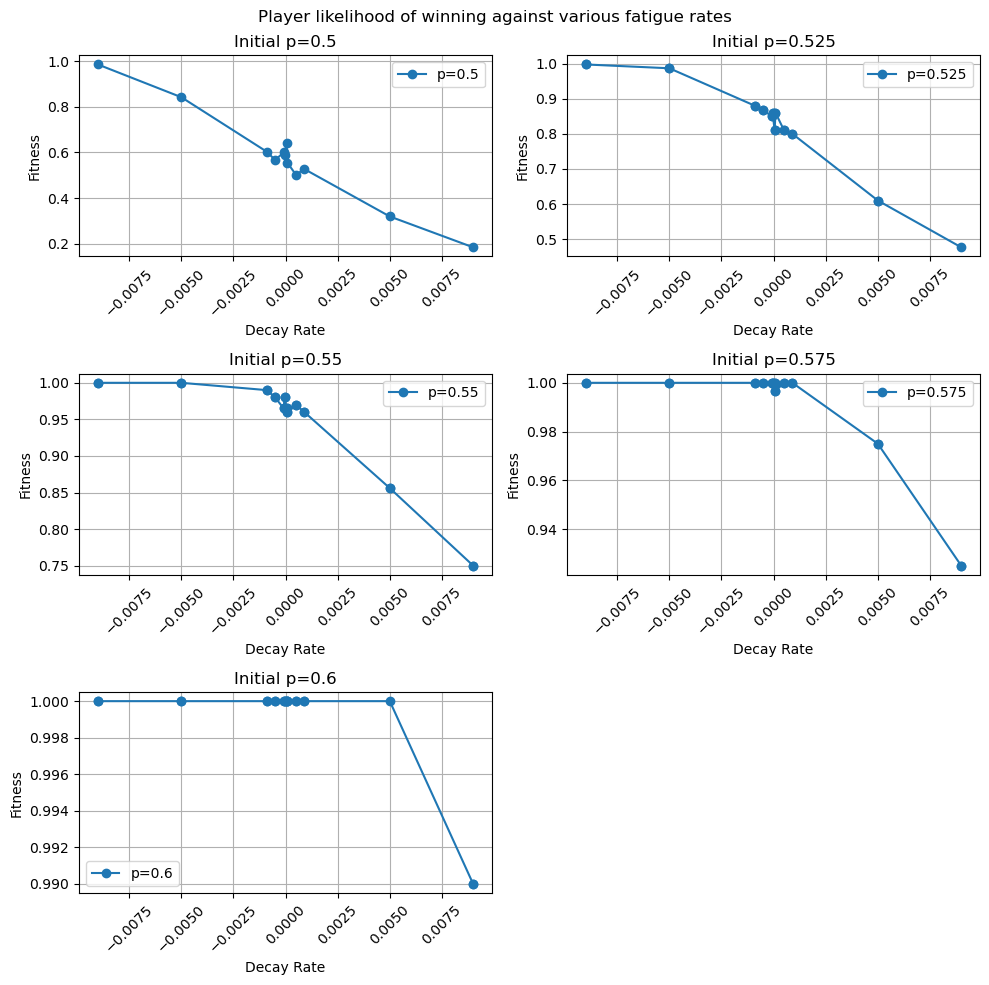

In [ ]:
def plot_fatigue_vs_fitness(player_fitness_list, zoom=False, save=False):
    n = len(player_fitness_list.keys())
    fig, axs = plt.subplots(n//2 + (n % 2), 2, figsize=(10, 10), squeeze=False)

    for i, p in enumerate(player_fitness_list.keys()):
        arr = [[player.rate_of_decay, fitness] for player, fitness in player_fitness_list[p] if not zoom or np.abs(player.rate_of_decay) < 0.005]
        arr.sort(key=lambda x: x[0])  # Sort by decay rate
        decay_rates = [decay_rate for decay_rate, _ in arr]
        fitnesses = [fitness for _,fitness in arr]
        axs[i//2, i%2].plot(decay_rates, fitnesses, marker='o', label=f'p={p}')
        axs[i//2, i%2].set_title(f'Initial p={p}')
        axs[i//2, i%2].set_xlabel('Decay Rate')
        axs[i//2, i%2].set_ylabel('p of winning the match')
        axs[i//2, i%2].tick_params(axis='x', rotation=45)
        axs[i//2, i%2].legend()
        axs[i//2, i%2].grid()

    fig.suptitle('Player likelihood of winning against various fatigue rates')
    axs_flatten = axs.flatten()
    for k in range(len(player_fitness_list.keys()), len(axs_flatten)):
        fig.delaxes(axs_flatten[k])  
    plt.tight_layout()
    if save:
        plt.savefig(f'fatigue_vs_fitness_zoom={zoom}.png')
    plt.show()
    

players = load_results('results.csv')
plot_fatigue_vs_fitness(players, save=True)

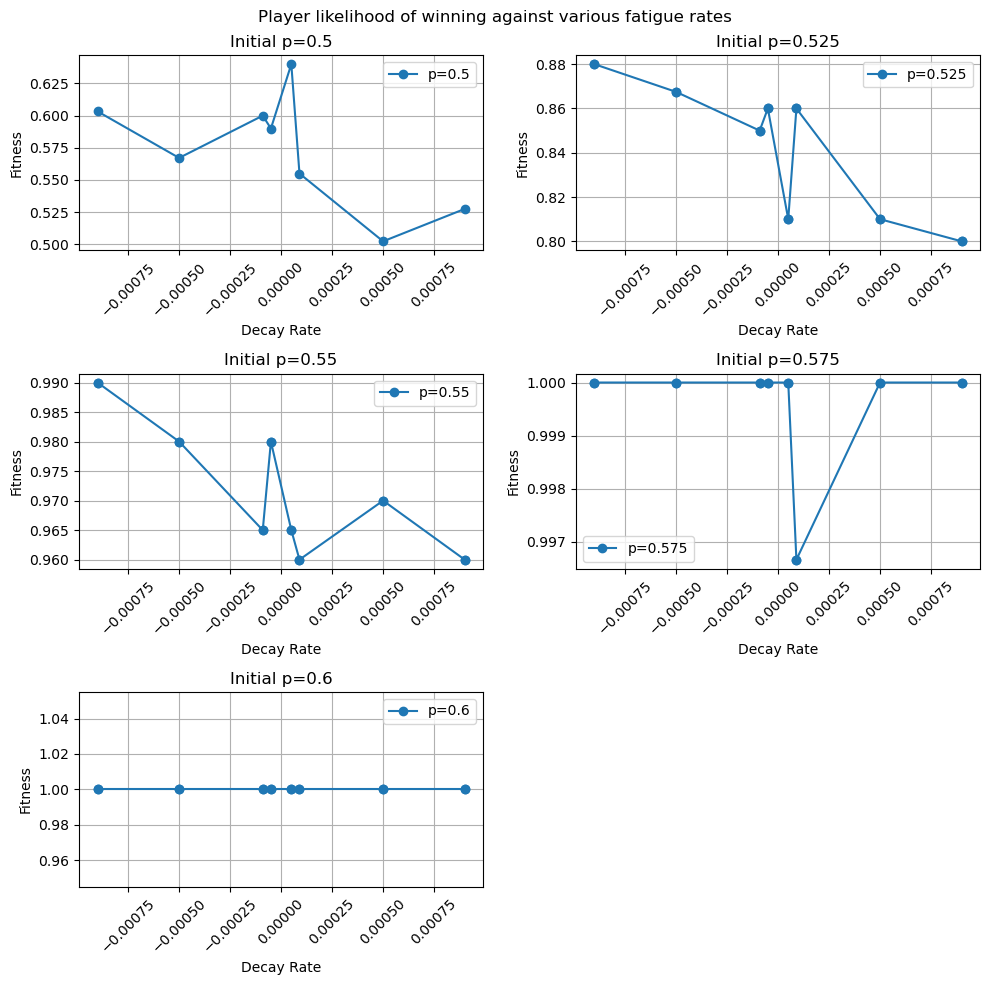

In [22]:
plot_fatigue_vs_fitness(players, zoom=True, save=True)

In [ ]:
def plot_p_vs_decay(player_fitness_list):
    

_IncompleteInputError: incomplete input (1263089625.py, line 1)